In [48]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from google.colab import drive

In [49]:
#drive access
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
IMAGE_WIDTH = 192
IMAGE_HEIGHT = 256
DATASET_PATH = '/content/drive/My Drive/Growth'
BATCH_SIZE = 16
EPOCHS = 25


In [68]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=( IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 404 files belonging to 2 classes.


In [69]:
classes_list = dataset.class_names

print(classes_list)

['3 months', '6 months']


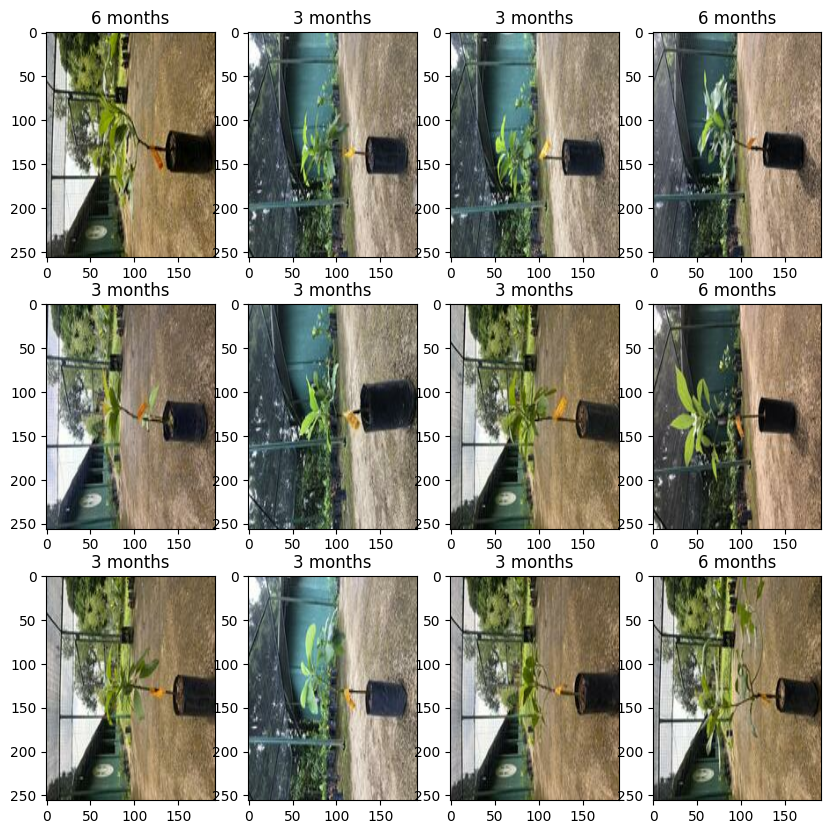

In [70]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for x in range (12):
        ax = plt.subplot(3,4, x+1)
        plt.axis("on")
        plt.title(classes_list[label_batch[x]])
        img = image_batch[x].numpy().astype("uint8")
        plt.imshow(img)


In [73]:
trainSize = int(0.8 * len(dataset))
valSize = int(0.1 * len(dataset))

In [74]:
def partitions_dataset(dataset , train = 0.8, val = 0.1, test = 0.1, shuffle = 10000):
    if shuffle:
          dataset = dataset.shuffle(shuffle, seed =12)

    train_set = dataset.take(trainSize)
    test_set = dataset.skip(trainSize)
    validation_set =  test_set.take(valSize)
    test_set = test_set.skip(valSize)
    return train_set, test_set, validation_set

In [75]:
train_set ,test_set, validation_set = partitions_dataset(dataset)

In [76]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_set = validation_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [77]:
resize_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT,IMAGE_WIDTH),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [112]:
data_augemntation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [113]:
model = models.Sequential([
    resize_rescale,
    data_augemntation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(None,None,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax'),
])

In [114]:
model.build(input_shape = (BATCH_SIZE, IMAGE_HEIGHT,IMAGE_WIDTH,3))

In [115]:
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 256, 192, 3)       0         
                                                                 
 sequential_16 (Sequential)  (16, 256, 192, 3)         0         
                                                                 
 conv2d_31 (Conv2D)          (16, 254, 190, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPooli  (16, 127, 95, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (16, 125, 93, 64)         18496     
                                                                 
 flatten_9 (Flatten)         (16, 744000)              0         
                                                     

In [116]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [117]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [118]:
history = model.fit(
    train_set,
    batch_size=BATCH_SIZE,
    validation_data=validation_set,
    verbose=1,
    epochs=10,
    callbacks=[callback]
)

Epoch 1/10
20/20 [==============================] - 3s 44ms/step - loss: 7.3817 - accuracy: 0.4750 - val_loss: 0.7277 - val_accuracy: 0.5312
Epoch 2/10
20/20 [==============================] - 1s 35ms/step - loss: 0.6071 - accuracy: 0.6719 - val_loss: 0.6065 - val_accuracy: 0.5625
Epoch 3/10
20/20 [==============================] - 1s 35ms/step - loss: 0.4066 - accuracy: 0.8094 - val_loss: 0.1813 - val_accuracy: 0.9688
Epoch 4/10
20/20 [==============================] - 1s 34ms/step - loss: 0.1434 - accuracy: 0.9625 - val_loss: 0.1571 - val_accuracy: 0.9375
Epoch 5/10
20/20 [==============================] - 1s 35ms/step - loss: 0.1209 - accuracy: 0.9563 - val_loss: 0.1295 - val_accuracy: 0.9375
Epoch 6/10
20/20 [==============================] - 1s 36ms/step - loss: 0.0660 - accuracy: 0.9750 - val_loss: 0.2799 - val_accuracy: 0.8438
Epoch 7/10
20/20 [==============================] - 1s 37ms/step - loss: 0.2758 - accuracy: 0.8844 - val_loss: 0.2999 - val_accuracy: 0.8438
Epoch 8/10
20

In [119]:
prediction = model.evaluate(test_set)

4/4 [==============================] - 0s 12ms/step - loss: 0.0349 - accuracy: 0.9844


In [120]:
prediction

[0.03493749350309372, 0.984375]

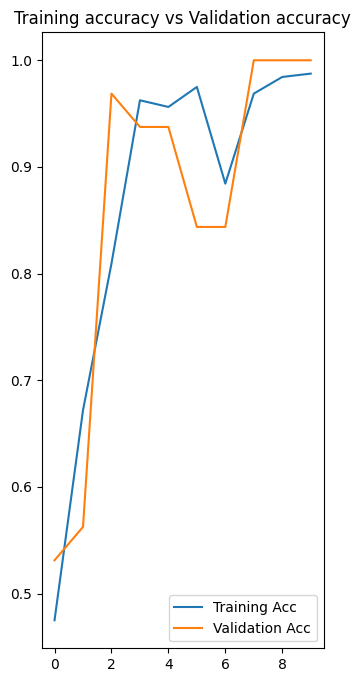

In [122]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("Training accuracy vs Validation accuracy")
plt.plot(range(10), history.history['accuracy'], label = 'Training Acc')
plt.plot(range(10), history.history['val_accuracy'], label = 'Validation Acc')
plt.legend(loc='lower right')
plt.title("Training accuracy vs Validation accuracy")

plt.show()

actual label: 3 months
1/1 [==============================] - 0s 28ms/step
predicted label: 3 months


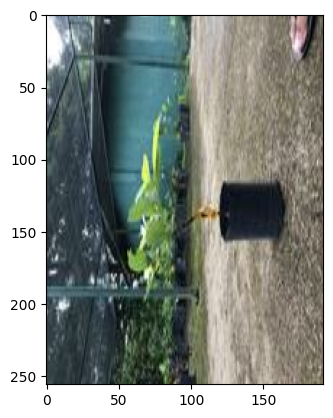

In [124]:
for images_batch, labels_batch in test_set.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("actual label:",classes_list[first_label])

    prediction = model.predict(images_batch)
    print("predicted label:",classes_list[np.argmax(prediction[0])])

In [125]:
model_path = '/content/drive/My Drive/growth_detection.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [126]:
model = tf.keras.models.load_model(model_path, compile=False)

In [127]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes_list[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


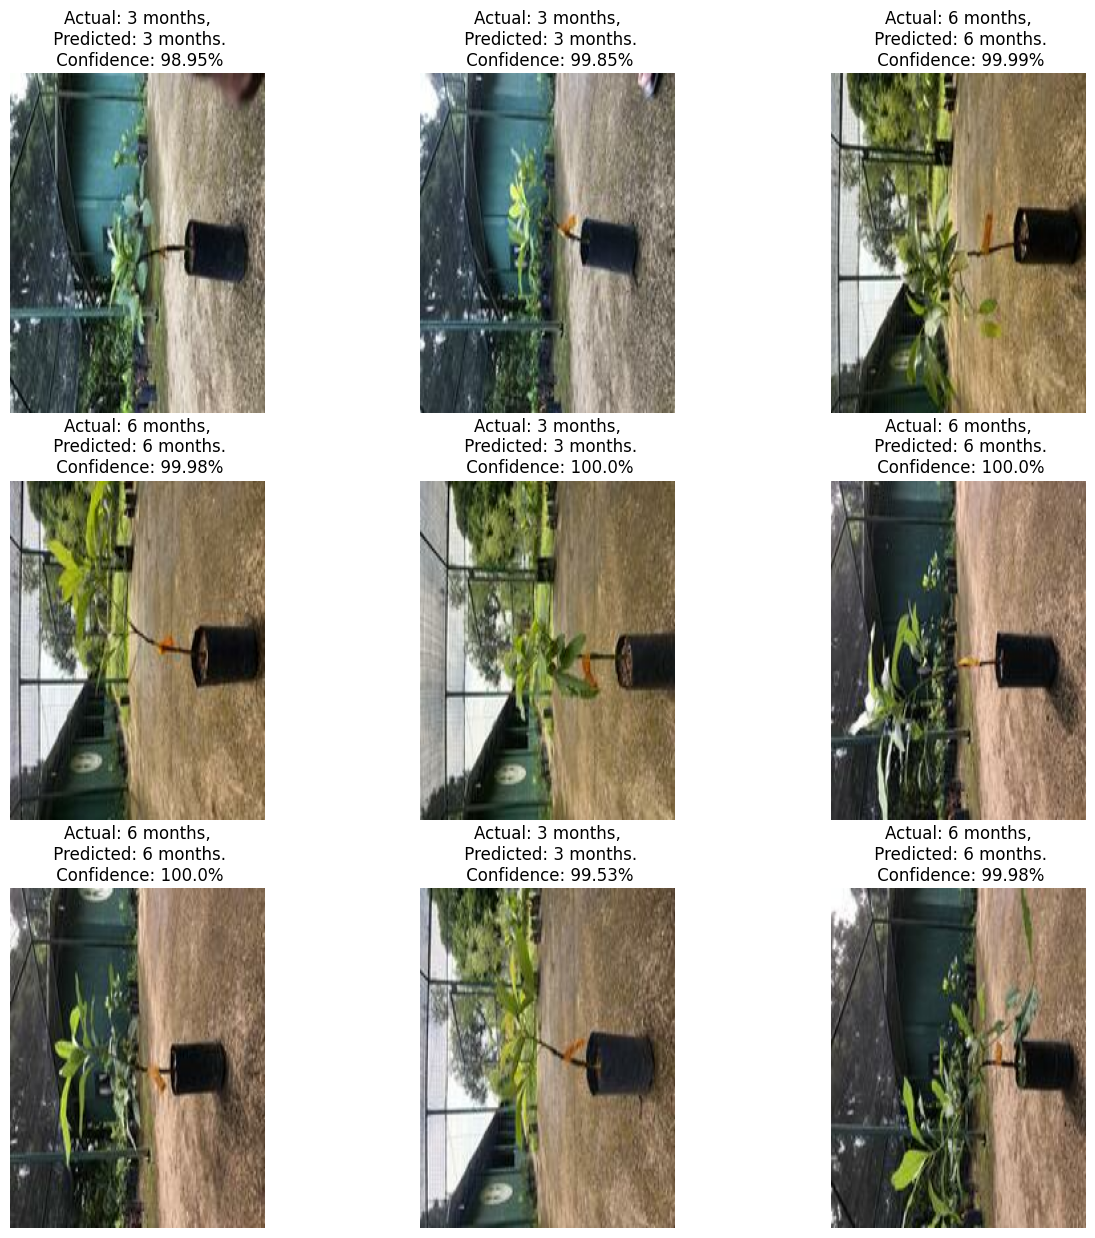

In [128]:
plt.figure(figsize=(15, 15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes_list[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")